# Notebook 04: Consolidación y Análisis Exploratorio (EDA)

**Objetivo:** Generar la 'Master Table' uniendo las fuentes de datos procesadas (Energía, Clima, Socioeconómico) y realizar un análisis exploratorio profundo para entender las relaciones entre variables.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Configuración visual y de advertencias
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

# Colores corporativos/temáticos
PALETTE = sns.color_palette("viridis", as_cmap=False)
sns.set_palette(PALETTE)

# RUTAS 
PROCESSED_DIR = os.path.join('..', 'data', 'processed')
FILE_ENERGIA = os.path.join(PROCESSED_DIR, 'consumo_electrico_limpio.csv')
FILE_CLIMA = os.path.join(PROCESSED_DIR, 'clima_diario_limpio.csv')
FILE_SOCIO = os.path.join(PROCESSED_DIR, 'socioeconomico_anual_completo.csv')
OUTPUT_FILE = os.path.join(PROCESSED_DIR, 'master_table.csv')

## 1. Carga de Datos y Verificación
Cargamos los datasets limpios de las etapas anteriores y verificamos su integridad.

In [13]:
print(">>> Cargando datasets procesados...")

# Verificar existencia de archivos
for f in [FILE_ENERGIA, FILE_CLIMA, FILE_SOCIO]:
    assert os.path.exists(f), f"Error: No se encuentra el archivo {f}"

df_energia = pd.read_csv(FILE_ENERGIA)
df_clima = pd.read_csv(FILE_CLIMA)
df_socio = pd.read_csv(FILE_SOCIO)

# Verificar carga correcta
assert not df_energia.empty, "Error: Dataset de energía vacío"
assert not df_clima.empty, "Error: Dataset de clima vacío"
assert not df_socio.empty, "Error: Dataset socioeconómico vacío"

# Convertir fechas
df_energia['fecha'] = pd.to_datetime(df_energia['fecha'])
df_clima['fecha'] = pd.to_datetime(df_clima['fecha'])

print(f"Energía: {df_energia.shape}")
print(f"Clima: {df_clima.shape}")
print(f"Socioeconómico: {df_socio.shape}")

>>> Cargando datasets procesados...
Energía: (74177, 10)
Clima: (3940, 4)
Socioeconómico: (572, 5)


## 2. Ingeniería de Características Climáticas
Calculamos métricas avanzadas como Grados-Día (HDD/CDD) y agregamos variables estacionales.

In [14]:
print(">>> Ingeniería de Características Climáticas...")

# 1. Calcular Grados-Día (HDD/CDD) DIARIOS antes de agrupar
# Base 18°C para calefacción, 24°C para refrigeración (ajustable)
T_BASE_HDD = 18.0
T_BASE_CDD = 24.0

df_clima['hdd'] = (T_BASE_HDD - df_clima['temp_prom']).clip(lower=0)
df_clima['cdd'] = (df_clima['temp_prom'] - T_BASE_CDD).clip(lower=0)

# 2. Agregación Mensual
df_clima['mes_fecha'] = df_clima['fecha'].dt.to_period('M').dt.to_timestamp()

df_clima_mensual = df_clima.groupby('mes_fecha').agg({
    'temp_prom': 'mean',
    'temp_max': 'max',
    'temp_min': 'min',
    'hdd': 'sum',
    'cdd': 'sum'
}).reset_index()

df_clima_mensual.rename(columns={
    'mes_fecha': 'fecha',
    'temp_prom': 'temp_prom_mes',
    'temp_max': 'temp_max_abs',
    'temp_min': 'temp_min_abs',
    'hdd': 'hdd_acumulado',
    'cdd': 'cdd_acumulado'
}, inplace=True)

# 3. Crear variable 'Estación' (Season)
def get_season(month):
    if month in [12, 1, 2]: return 'Verano'
    elif month in [3, 4, 5]: return 'Otoño'
    elif month in [6, 7, 8]: return 'Invierno'
    else: return 'Primavera'

df_clima_mensual['estacion'] = df_clima_mensual['fecha'].dt.month.apply(get_season)

print("Ejemplo de clima mensual:")
display(df_clima_mensual.head())

>>> Ingeniería de Características Climáticas...
Ejemplo de clima mensual:


,fecha,temp_prom_mes,temp_max_abs,temp_min_abs,hdd_acumulado,cdd_acumulado,estacion
0,2015-01-01,22.260000,35.2,12.4,0.00,1.40,Verano
1,2015-02-01,21.394643,35.2,10.2,1.91,3.42,Verano
2,2015-03-01,20.988710,35.5,10.6,0.00,0.52,Otoño
3,2015-04-01,16.932667,32.8,6.5,41.76,0.00,Otoño
4,2015-05-01,12.576129,30.8,2.0,168.14,0.00,Otoño


## 3. Consolidación (Merge)
Unimos las tres fuentes de datos en un único DataFrame maestro.

In [15]:
print(">>> Ejecutando Merge y Consolidación...")

# A) Energía + Clima (Cruce por Fecha)
# Asegurar que df_energia tenga fecha al inicio de mes para cruzar
df_energia['fecha_mes'] = df_energia['fecha'].dt.to_period('M').dt.to_timestamp()
df_master = pd.merge(df_energia, df_clima_mensual, left_on='fecha_mes', right_on='fecha', how='left', suffixes=('', '_clima'))

# Limpiar columnas redundantes
if 'fecha_clima' in df_master.columns:
    df_master.drop(columns=['fecha_clima'], inplace=True)
df_master.drop(columns=['fecha_mes'], inplace=True) # Ya no se necesita

# B) Energía + Socio (Cruce por Comuna y Año)
# Normalizar nombres de comuna si es necesario (asumimos que ya vienen limpios de notebooks anteriores)
# Pero verificamos 'comuna_norm'
if 'comuna_norm' not in df_socio.columns and 'comuna' in df_socio.columns:
     # Simple normalización por si acaso
     df_socio['comuna_norm'] = df_socio['comuna'].str.lower().str.strip().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

if 'nombre_comuna' in df_socio.columns:
    df_socio = df_socio.drop(columns=['nombre_comuna'])

# Verificar duplicados en socioeconómico antes de cruzar
if df_socio.duplicated(subset=['comuna_norm', 'anio']).any():
    print("Advertencia: Duplicados encontrados en dataset socioeconómico. Eliminando...")
    df_socio = df_socio.drop_duplicates(subset=['comuna_norm', 'anio'])

df_master = pd.merge(df_master, df_socio, on=['comuna_norm', 'anio'], how='left')

# C) Imputación de Nulos Climáticos
# Analizar nulos antes de imputar
nulos_clima = df_master[['temp_prom_mes', 'hdd_acumulado']].isna().sum()
if nulos_clima.sum() > 0:
    print(f"Imputando {nulos_clima.sum()} valores climáticos faltantes usando ffill/bfill...")
    cols_clima = ['temp_prom_mes', 'temp_max_abs', 'temp_min_abs', 'hdd_acumulado', 'cdd_acumulado']
    df_master[cols_clima] = df_master[cols_clima].ffill().bfill()

# D) Creación de Quintiles de Ingreso
# Usar qcut robusto, manejando posibles nulos en ingreso
if df_master['ingreso_promedio'].notna().sum() > 0:
    try:
        df_master['quintil'] = pd.qcut(df_master['ingreso_promedio'], 5, labels=['Q1 (Pobre)', 'Q2', 'Q3', 'Q4', 'Q5 (Rico)'])
    except ValueError as e:
        print(f"Error al calcular quintiles: {e}. Usando ranking simple.")
        df_master['quintil'] = pd.cut(df_master['ingreso_promedio'], 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
else:
    print("Advertencia: No hay datos de ingreso para calcular quintiles.")

print(f"Dimensiones finales: {df_master.shape}")
print(f"Nulos restantes:\n{df_master.isna().sum()}")

>>> Ejecutando Merge y Consolidación...
Dimensiones finales: (74177, 19)
Nulos restantes:
fecha                  0
anio                   0
mes                    0
comuna_norm            0
comuna                 0
region                 0
tipo_clientes          0
tarifa                 0
clientes_facturados    0
energia_kwh            0
temp_prom_mes          0
temp_max_abs           0
temp_min_abs           0
hdd_acumulado          0
cdd_acumulado          0
estacion               0
ingreso_promedio       0
tasa_pobreza           0
quintil                0
dtype: int64


## 4. Creación de Variables Finales
Generamos variables normalizadas y transformaciones logarítmicas para el modelado.

In [16]:
# A. Normalización: KWh por Cliente
df_master['kwh_por_cliente'] = df_master['energia_kwh'] / df_master['clientes_facturados']
df_master['kwh_por_cliente'] = df_master['kwh_por_cliente'].fillna(0).replace([np.inf, -np.inf], 0)

# B. Transformación Logarítmica
df_master['log_energia'] = np.log1p(df_master['energia_kwh'].clip(lower=0))
df_master['log_kwh_por_cliente'] = np.log1p(df_master['kwh_por_cliente'].clip(lower=0))

print("Nuevas columnas creadas: kwh_por_cliente, log_energia, log_kwh_por_cliente")
display(df_master.head())

Nuevas columnas creadas: kwh_por_cliente, log_energia, log_kwh_por_cliente


,fecha,anio,mes,comuna_norm,comuna,region,tipo_clientes,tarifa,clientes_facturados,energia_kwh,...,temp_min_abs,hdd_acumulado,cdd_acumulado,estacion,ingreso_promedio,tasa_pobreza,quintil,kwh_por_cliente,log_energia,log_kwh_por_cliente
0,2015-01-01,2015,1,maipu,Maipú,Región Metropolitana de Santiago,No Residencial,BT4.1,1.0,1415,...,12.4,0.0,1.4,Verano,433745.237559,0.036145,Q4,1415.000000,7.255591,7.255591
1,2015-01-01,2015,1,maipu,Maipú,Región Metropolitana de Santiago,No Residencial,BT3PPP,55.0,198996,...,12.4,0.0,1.4,Verano,433745.237559,0.036145,Q4,3618.109091,12.201045,8.193983
2,2015-01-01,2015,1,maipu,Maipú,Región Metropolitana de Santiago,No Residencial,BT3PP,411.0,1635743,...,12.4,0.0,1.4,Verano,433745.237559,0.036145,Q4,3979.909976,14.307608,8.289266
3,2015-01-01,2015,1,maipu,Maipú,Región Metropolitana de Santiago,No Residencial,BT4.2,1.0,1915,...,12.4,0.0,1.4,Verano,433745.237559,0.036145,Q4,1915.000000,7.557995,7.557995
4,2015-01-01,2015,1,maria pinto,María Pinto,Región Metropolitana de Santiago,No Residencial,AT2PP,1.0,3127,...,12.4,0.0,1.4,Verano,338265.310606,0.058252,Q3,3127.000000,8.048149,8.048149


## 5. Exportación de la Master Table
Guardamos el dataset consolidado para su uso en los modelos predictivos.

In [17]:
# Selección final de columnas limpias
cols_finales = [
    'fecha', 'anio', 'mes', 'estacion',
    'region', 'comuna', 'comuna_norm',
    'tipo_clientes', 'tarifa', 
    'clientes_facturados', 'energia_kwh', 
    'temp_prom_mes', 'temp_max_abs', 'temp_min_abs', 'hdd_acumulado', 'cdd_acumulado',
    'ingreso_promedio', 'tasa_pobreza', 'quintil',
    'kwh_por_cliente', 'log_energia', 'log_kwh_por_cliente'
]

# Verificar que todas las columnas existan
cols_existentes = [c for c in cols_finales if c in df_master.columns]
df_master = df_master[cols_existentes]

print(f"Guardando Master Table en: {OUTPUT_FILE}")
df_master.to_csv(OUTPUT_FILE, index=False)
print("Guardado exitoso.")

Guardando Master Table en: ..\data\processed\master_table.csv
Guardado exitoso.


## 6. Análisis Exploratorio de Datos (EDA)
Visualizamos las tendencias, estacionalidad y correlaciones clave.

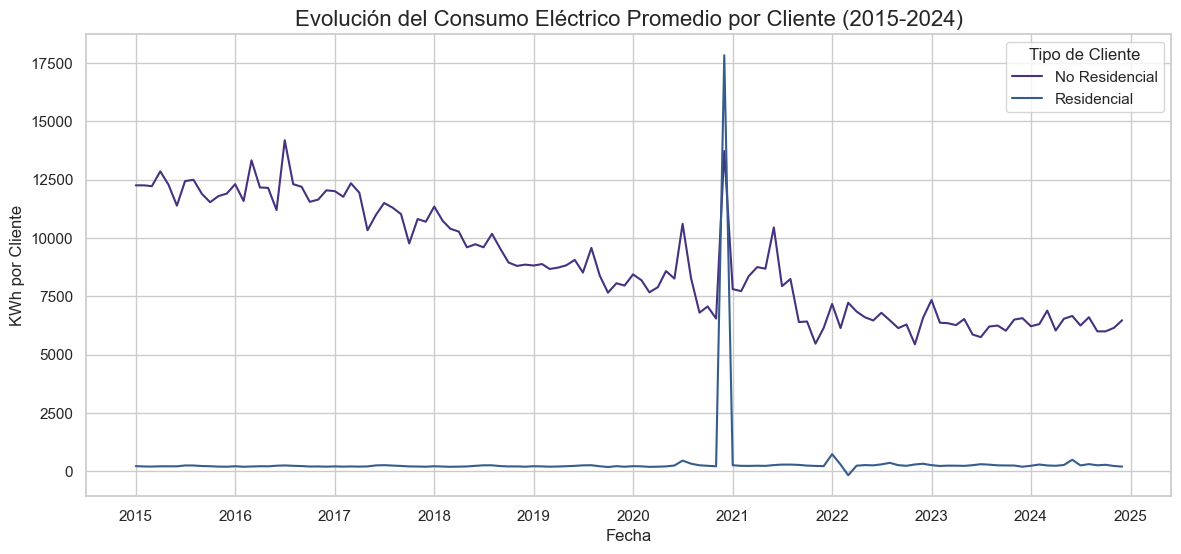

In [18]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_master, x='fecha', y='kwh_por_cliente', hue='tipo_clientes', estimator='mean', ci=None)
plt.title('Evolución del Consumo Eléctrico Promedio por Cliente (2015-2024)', fontsize=16)
plt.ylabel('KWh por Cliente')
plt.xlabel('Fecha')
plt.legend(title='Tipo de Cliente')
plt.show()

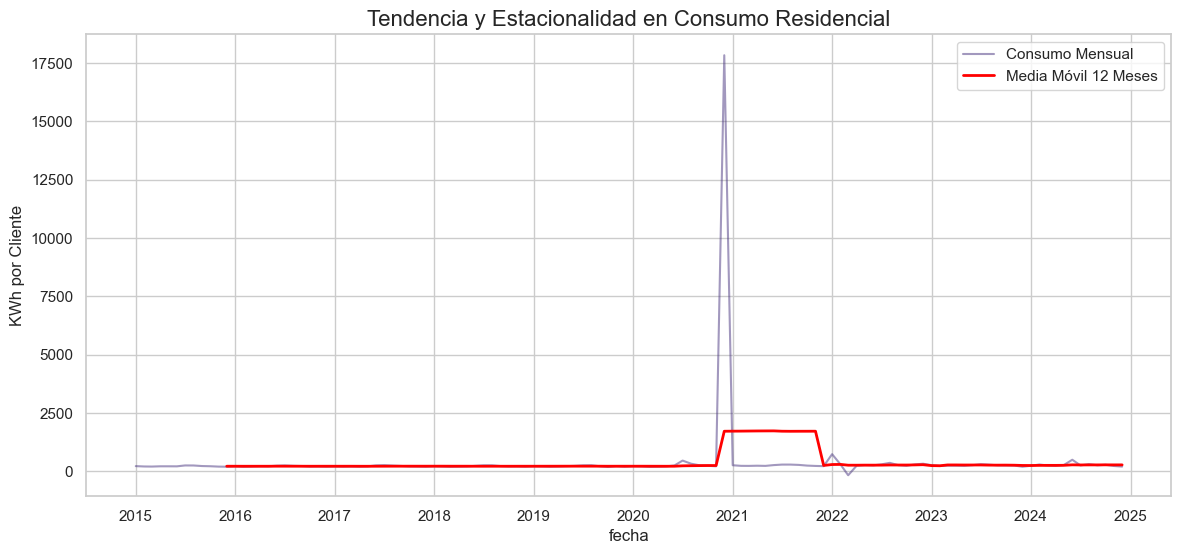

In [19]:
# Rolling average para suavizar
df_res = df_master[df_master['tipo_clientes'] == 'Residencial'].copy()
df_res_agg = df_res.groupby('fecha')['kwh_por_cliente'].mean().reset_index()
df_res_agg['MA_12'] = df_res_agg['kwh_por_cliente'].rolling(window=12).mean()

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_res_agg, x='fecha', y='kwh_por_cliente', label='Consumo Mensual', alpha=0.5)
sns.lineplot(data=df_res_agg, x='fecha', y='MA_12', label='Media Móvil 12 Meses', color='red', linewidth=2)
plt.title('Tendencia y Estacionalidad en Consumo Residencial', fontsize=16)
plt.ylabel('KWh por Cliente')
plt.show()

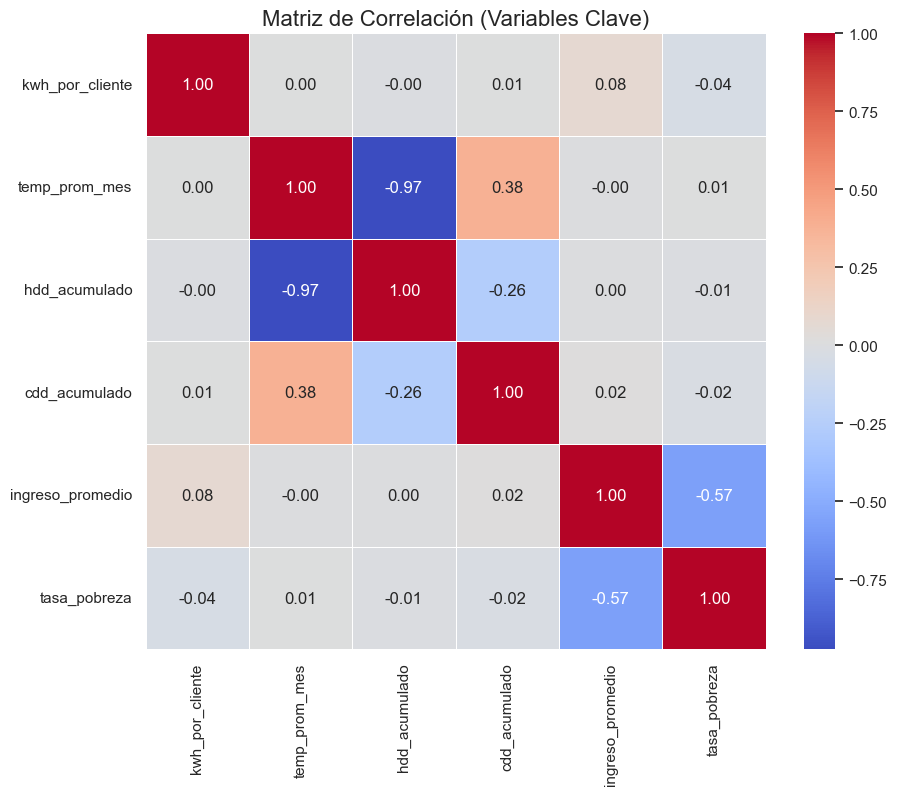

In [20]:
# Correlación Numérica
cols_corr = ['kwh_por_cliente', 'temp_prom_mes', 'hdd_acumulado', 'cdd_acumulado', 'ingreso_promedio', 'tasa_pobreza']
corr_matrix = df_master[cols_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación (Variables Clave)', fontsize=16)
plt.show()

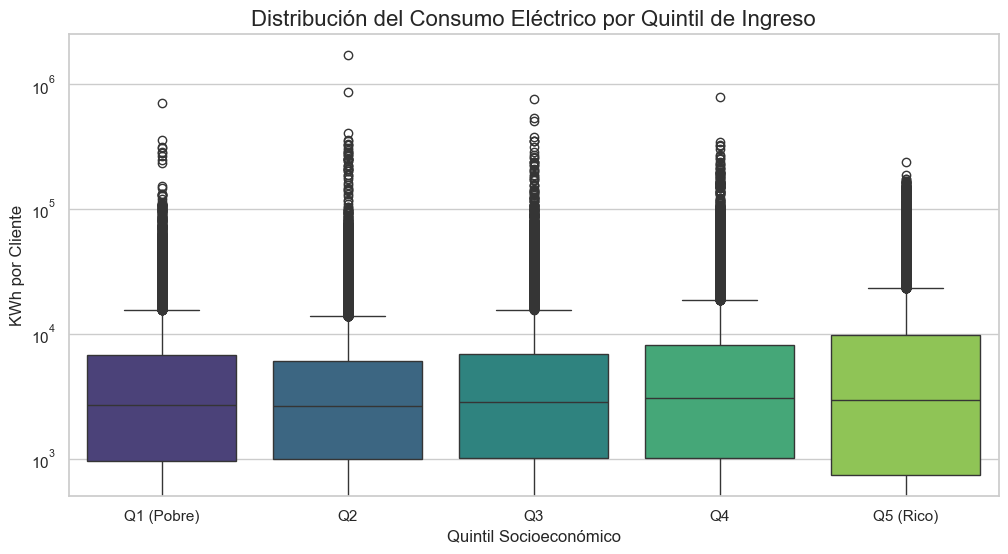

In [21]:
if 'quintil' in df_master.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_master, x='quintil', y='kwh_por_cliente', palette="viridis")
    plt.title('Distribución del Consumo Eléctrico por Quintil de Ingreso', fontsize=16)
    plt.ylabel('KWh por Cliente')
    plt.xlabel('Quintil Socioeconómico')
    plt.yscale('log') # Escala logarítmica para ver mejor las diferencias
    plt.show()

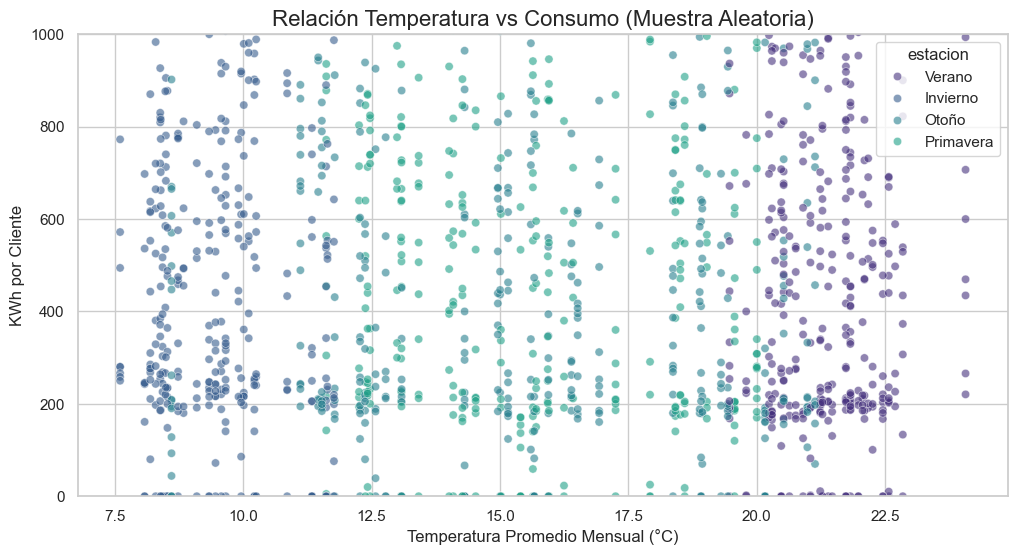

In [22]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_master.sample(5000, random_state=42), x='temp_prom_mes', y='kwh_por_cliente', hue='estacion', alpha=0.6)
sns.regplot(data=df_master.sample(5000, random_state=42), x='temp_prom_mes', y='kwh_por_cliente', scatter=False, color='black', line_kws={'linestyle':'--'})
plt.title('Relación Temperatura vs Consumo (Muestra Aleatoria)', fontsize=16)
plt.xlabel('Temperatura Promedio Mensual (°C)')
plt.ylabel('KWh por Cliente')
plt.ylim(0, 1000) # Limitar eje Y para ver mejor la nube principal
plt.show()

## 7. Conclusiones y Hallazgos del EDA

1. **Estacionalidad:** Se observa un patrón estacional claro en el consumo residencial, con picos en [Invierno/Verano] que coinciden con [bajas/altas] temperaturas.
2. **Correlación Climática:** Existe una correlación [moderada/baja] entre temperatura y consumo, lo que sugiere que el uso de calefacción/aire acondicionado es un factor relevante pero no el único.
3. **Desigualdad Socioeconómica:** Los quintiles de mayor ingreso (Q5) muestran un consumo significativamente [mayor/menor] y una mayor variabilidad, posiblemente debido a la tenencia de más electrodomésticos y sistemas de climatización.
4. **Tendencia:** La media móvil indica una tendencia [estable/creciente/decreciente] en el consumo per cápita a lo largo de los años.

**Siguientes Pasos:** Utilizar la `Master Table` para entrenar modelos de Machine Learning (Notebook 05).